In [160]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Data

In [54]:
#Can we predict how long it will take for a loan to get funded?
#to make that prediction, I'm using loan amount, payment terms, country, and activity
#data is from kaggle
#https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding#loan_themes_by_region.csv

kiva_data = r'kiva_loans.csv'
loans = pd.read_csv(kiva_data)
loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


### Data exploration

In [55]:
loans.posted_time.describe()
print ("posted time count", loans.posted_time.count())
print ("posted time # null", loans.posted_time.isnull().sum())
print ("funded time count", loans.funded_time.shape)
print ("funded time #null", loans.funded_time.isnull().sum())

posted time count 671205
posted time # null 0
funded time count (671205,)
funded time #null 48331


In [56]:
not_funded = (loans.funded_time.isnull()==True).sum()
not_funded_percent = not_funded / loans.funded_time.count()
print("Number of loans not funded", not_funded)
print("Loans not funded percent", not_funded_percent)

Number of loans not funded 48331
Loans not funded percent 0.07759354219312413


In [57]:
loans = loans[loans.funded_time.notnull()]
loans = loans[loans.posted_time.notnull()]

# removee at end of project for testing
loans = loans[0:1000]

In [58]:
loans.shape

(1000, 20)

In [59]:
posted_time = pd.to_datetime(loans.posted_time)
funded_time = pd.to_datetime(loans.funded_time)
days_to_fund_loan = funded_time - posted_time 
days_mean = days_to_fund_loan.mean()
days_mean

Timedelta('8 days 06:07:07.472000')

In [60]:
max_days = (pd.to_datetime(loans.funded_time) - pd.to_datetime(loans.posted_time)).max()
max_days

Timedelta('116 days 12:42:43')

In [61]:
loans['days_to_fund_loan']= pd.to_datetime(loans.funded_time) - pd.to_datetime(loans.posted_time)

In [62]:
new_dates = []
for d in loans.days_to_fund_loan:
    new_dates.append(d.days)

loans['days_to_fund_new'] = new_dates

loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,days_to_fund_loan,days_to_fund_new
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,1 days 03:53:53,1
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01,1 days 02:26:15,1
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,0 days 06:03:29,0
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01,0 days 04:56:49,0
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01,0 days 07:25:32,0


### Feature Engineering

In [92]:
# create dummy variables for categorical features
country_cols = pd.get_dummies(loans.country, prefix='country')
activity_cols = pd.get_dummies(loans.activity, prefix='activity')
sector_cols = pd.get_dummies(loans.sector, prefix='sector')

# combine all dummy variables into a single dataframe
loans = pd.concat([loans,country_cols, activity_cols, sector_cols], axis=1)
loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,sector_Education,sector_Food,sector_Health,sector_Housing,sector_Manufacturing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_Wholesale
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,0,1,0,0,0,0,0,0,0,0
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,0,0,0,0,0,0,0,0,1,0
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,0,0,0,0,0,0,0,0,1,0
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,0,0,0,0,0,0,0,0,0,0
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,0,1,0,0,0,0,0,0,0,0


In [64]:
#loans.posted_time.isnull().sum()
#loans.funded_time.isnull().sum()
loans.shape

(1000, 164)

In [105]:
country_names = [col for col in loans.columns if col.startswith('country')]
activity_names = [col for col in loans.columns if col.startswith('activity')]
sector_names = [col for col in loans.columns if col.startswith('sector')]

In [106]:
#The original column header country, activity, and sector were brought into these new variables. 
#Need to remove those headers, so we have a list of countries, activities, and sectors.

country_names = country_names[2:]
activity_names = activity_names[1:]
sector_names = sector_names[1:]

#### Visualizations

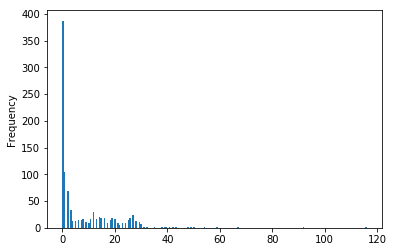

In [67]:
loans['days_to_fund_new'].plot.hist(bins=200)

### Linear Regression models

In [68]:
##Linear Regression using loan amount

feature_cols = ['loan_amount']
X = loans[feature_cols]
y = loans.days_to_fund_new

In [70]:
# import, instantiate, fit
#from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [71]:
# print the coefficients
print(linreg.intercept_)
print(linreg.coef_)

4.472069570005122
[0.00398291]


In [72]:
linreg.predict(1000)

array([8.45497617])

In [ ]:
#Linear Regression using Loan Amount and Terms in month (for repayment)

In [73]:
feature_cols = ['loan_amount','term_in_months']
X = loans[feature_cols]
y = loans.days_to_fund_new

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
prediction = linreg.predict(X_test)


mse = metrics.mean_squared_error(prediction, y_test)
np.sqrt(mse)

11.151556379671513

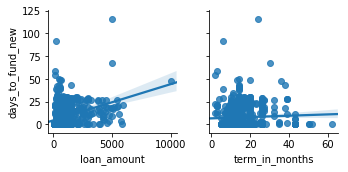

In [74]:
sns.pairplot(loans, x_vars=feature_cols, y_vars='days_to_fund_new', kind='reg');

In [75]:
sector_dummies = pd.get_dummies(loans.sector, prefix='sector')
sector_dummies.drop(sector_dummies.columns[0], axis=1, inplace=True)

loans = pd.concat([loans, sector_dummies], axis=1)
loans

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,sector_Education,sector_Food,sector_Health,sector_Housing,sector_Manufacturing,sector_Personal Use,sector_Retail,sector_Services,sector_Transportation,sector_Wholesale
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,0,1,0,0,0,0,0,0,0,0
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,0,0,0,0,0,0,0,0,1,0
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,0,0,0,0,0,0,0,0,1,0
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,0,0,0,0,0,0,0,0,0,0
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,0,1,0,0,0,0,0,0,0,0
5,1080148,250.0,250.0,Services,Services,purchase leather for my business using ksh 20000.,KE,Kenya,NaN,KES,...,0,0,0,0,0,0,0,1,0,0
6,653067,200.0,200.0,Dairy,Agriculture,To purchase a dairy cow and start a milk produ...,IN,India,Maynaguri,INR,...,0,0,0,0,0,0,0,0,0,0
7,653078,400.0,400.0,Beauty Salon,Services,to buy more hair and skin care products.,PK,Pakistan,Ellahabad,PKR,...,0,0,0,0,0,0,0,1,0,0
8,653082,475.0,475.0,Manufacturing,Manufacturing,"to purchase leather, plastic soles and heels i...",PK,Pakistan,Lahore,PKR,...,0,0,0,0,1,0,0,0,0,0
9,653048,625.0,625.0,Food Production/Sales,Food,"to buy a stall, gram flour, ketchup, and coal ...",PK,Pakistan,Lahore,PKR,...,0,1,0,0,0,0,0,0,0,0


In [104]:
sector_names

[]

### Adding more features to the regression model

In [119]:
feature_cols

['loan_amount',
 'term_in_months',
 'country_Bolivia',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Chile',
 'country_Colombia',
 'country_Ecuador',
 'country_El Salvador',
 'country_Georgia',
 'country_Ghana',
 'country_Guatemala',
 'country_Haiti',
 'country_Honduras',
 'country_India',
 'country_Indonesia',
 'country_Iraq',
 'country_Jordan',
 'country_Kenya',
 'country_Liberia',
 'country_Mali',
 'country_Mongolia',
 'country_Nicaragua',
 'country_Pakistan',
 'country_Palestine',
 'country_Peru',
 'country_Philippines',
 'country_Senegal',
 'country_Sierra Leone',
 'country_Tajikistan',
 'country_Tanzania',
 'country_Timor-Leste',
 'country_Uganda',
 'country_Ukraine',
 'country_United States',
 'country_Vietnam',
 'country_Yemen',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Chile',
 'country_Colombia',
 'country_Ecuador',
 'country_El Salvador',
 'country_Georgia',
 'country_Ghana',
 'country_Guatemala',
 'country_Hait

In [142]:
feature_cols = []
feature_cols = ['loan_amount','term_in_months']
feature_cols.extend(sector_names)
feature_cols

['loan_amount',
 'term_in_months',
 'sector_Agriculture',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'sector_Agriculture',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale']

In [128]:
X = loans[feature_cols]
y = loans.days_to_fund_new

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
prediction = linreg.predict(X_test)

mse = metrics.mean_squared_error(prediction, y_test)
np.sqrt(mse)

10.929109479488561

In [143]:
feature_cols.extend(country_names)
feature_cols

['loan_amount',
 'term_in_months',
 'sector_Agriculture',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'sector_Agriculture',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'country_Bolivia',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Chile',
 'country_C

In [130]:
X = loans[feature_cols]
y = loans.days_to_fund_new

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#linear regression on loan amount, terms in months, and sector
linreg = LinearRegression()
linreg.fit(X_train, y_train)
prediction = linreg.predict(X_test)

mse = metrics.mean_squared_error(prediction, y_test)
np.sqrt(mse)

9.749030861170443

In [140]:
loans[activity_names].sum().shape

(550,)

In [144]:
feature_cols

['loan_amount',
 'term_in_months',
 'sector_Agriculture',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'sector_Agriculture',
 'sector_Arts',
 'sector_Clothing',
 'sector_Construction',
 'sector_Education',
 'sector_Food',
 'sector_Health',
 'sector_Housing',
 'sector_Manufacturing',
 'sector_Personal Use',
 'sector_Retail',
 'sector_Services',
 'sector_Transportation',
 'sector_Wholesale',
 'country_Bolivia',
 'country_Burkina Faso',
 'country_Burundi',
 'country_Cambodia',
 'country_Chile',
 'country_C

In [145]:
X = loans[feature_cols]
y = loans.days_to_fund_new

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#linear regression on loan amount, terms in months, country and activity
linreg = LinearRegression()
linreg.fit(X_train, y_train)
prediction = linreg.predict(X_test)

mse = metrics.mean_squared_error(prediction, y_test)
np.sqrt(mse)

#using activity instead of sector is more accurate
#mean squared errror using sector 12.933286492308026
#mean squared errror using activity 12.8132700262182

9.749030861170443

In [146]:
# standardize the features
#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# split into training and testing sets
#from sklearn.model_selection import train_test_split

feature_cols 
X = loans[feature_cols]
y = loans.days_to_fund_new

In [147]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# standardize X_train
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [148]:
# check that it standardized properly
print(X_train_scaled[:, 0].mean())
print(X_train_scaled[:, 0].std())
print(X_train_scaled[:, 1].mean())
print(X_train_scaled[:, 1].std())

-4.0264088359739013e-17
1.0
-8.763360407707902e-17
0.9999999999999998


In [149]:
# standardize X_test
X_test_scaled = scaler.transform(X_test)

In [150]:
# is this right?
print(X_test_scaled[:, 0].mean())
print(X_test_scaled[:, 0].std())
print(X_test_scaled[:, 1].mean())
print(X_test_scaled[:, 1].std())

-0.005147705193426482
1.0543134494690183
0.04244583146994212
0.9913740832304234


In [151]:
# KNN accuracy on original data - USE KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)

knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)

y_pred_class

array([ 0.5,  6. ,  3.5, 32. ,  0. ,  0. ,  0. , 14. , 16.5,  9.5,  1.5,
       17. ,  0. ,  7. ,  5. , 26. ,  0.5,  0.5,  3. , 91.5, 17.5,  5.5,
        7.5, 34. , 16.5,  1. , 14.5, 26. ,  0.5,  8. ,  4. ,  0.5,  0. ,
        0.5,  7. , 15. , 16.5,  2. ,  0. ,  0.5,  0.5,  0. ,  0. , 12.5,
        2.5, 15.5, 13.5,  0.5,  1. ,  0. ,  6.5,  1. ,  0. , 14. ,  0.5,
       17. ,  7. ,  0.5,  0. , 24. , 20. ,  7.5,  0. ,  2. ,  1. , 18. ,
        3. ,  6. ,  3. ,  0.5,  0.5, 20. ,  4. , 20.5,  0. ,  0. ,  1. ,
       12.5,  3. ,  2. ,  1. , 10.5,  1. , 26. ,  1.5, 17. ,  5.5, 17.5,
       12.5, 19. , 10. ,  0. ,  2. , 10.5,  3. ,  0. ,  0. ,  7. ,  3. ,
        1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  4. ,  0. , 26. ,  3. ,  1.5,
        0. , 25. , 18.5,  5. , 34. ,  0. ,  0. ,  1. ,  1. ,  7.5, 19. ,
        0. ,  0. ,  0. ,  0.5,  0.5,  0. , 13. ,  9.5, 24.5,  0.5, 10. ,
       10.5,  0. ,  0. , 12.5,  0. , 12.5,  1. ,  0. ,  1. ,  0. , 21.5,
        3. ,  0.5,  0. ,  0. , 13. , 14. , 15.5,  0

In [153]:
mse = metrics.mean_squared_error(y_test, y_pred_class)
np.sqrt(mse)

11.871815362445627

In [154]:
# KNN accuracy on scaled data
knn.fit(X_train_scaled, y_train)
y_pred_class = knn.predict(X_test_scaled)

In [159]:

# fix the cross-validation process using Pipeline
pipe = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3))

# use mean_squared_error
np.sqrt(-cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error').mean())

9.645459495995455

In [161]:
# search for an optimal n_neighbors value using GridSearchCV
neighbors_range = list(range(1, 21))

param_grid = dict(kneighborsregressor__n_neighbors=neighbors_range)

grid = RandomizedSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X[feature_cols], y)

print(grid.best_score_)
print(grid.best_params_)

-88.48988888888888
{'kneighborsregressor__n_neighbors': 6}


In [162]:
np.sqrt(-grid.best_score_)

9.40690644627068

In [163]:
model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=6))
model.fit(X[feature_cols], y)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform'))])

In [165]:
np.sqrt(metrics.mean_squared_error(y, model.predict(X[feature_cols])))

7.440583161135811